In [1]:
import pickle as pkl
import os
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def getPickel(path):
    file = open(path,'rb')
    obj =  pkl.load(file)
    return obj

def putPickel(var,path):
    file = open(path,'wb')
    pkl.dump(var,file)
    file.close()

In [2]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [3]:
data_y = getPickel("/scratch/sisodiya.bhoomendra/labels.pkl")
X = getPickel("/scratch/sisodiya.bhoomendra/X_size_asm_1_Class_1_asm_51_byte_2000_size_1_asm_img_800.pkl")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, data_y,stratify=data_y,test_size=0.20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [8]:
x_cfl=XGBClassifier(tree_method='gpu_hist',)

prams={
    'learning_rate':[0.1,0.15,0.2],
     'n_estimators':[500,1000,2000],
     'max_depth':[3,5,7,10],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=20,)
random_cfl.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5; 3/10] START colsample_bytree=1, learning_rate=0.2, max_depth=3, n_estimators=2000, subsample=0.5
[CV 2/5; 3/10] END colsample_bytree=1, learning_rate=0.2, max_depth=3, n_estimators=2000, subsample=0.5;, score=0.994 total time=13.8min
[CV 3/5; 1/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=7, n_estimators=1000, subsample=0.3
[CV 3/5; 1/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=7, n_estimators=1000, subsample=0.3;, score=nan total time=   5.8s
[CV 3/5; 6/10] START colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.3
[CV 3/5; 6/10] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.3;, score=nan total time=   0.8s
[CV 2/5; 7/10] START colsample_bytree=0.3, learning_rate=0.2, max_depth=3, n_estimators=2000, subsample=0.3
[CV 2/5; 7/10] END colsample_bytree=0.3, learning_rate=0.2, max_depth=3, n_estimators=2000, subsample=

/home2/sisodiya.bhoomendra/venvs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
34 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home2/sisodiya.bhoomendra/venvs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home2/sisodiya.bhoomendra/venvs/test/lib/python3.9/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home2/sisodiya.bhoomendra/venvs/test/lib/python3.9/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booste

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=20,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 1],
                                        'learning_rate': [0.1, 0.15, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [500, 1000, 2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

In [9]:
import gc
gc.collect()

1368

In [13]:
random_cfl.best_params_

{'subsample': 0.5,
 'n_estimators': 2000,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [10]:
bxclf = random_cfl.best_estimator_

In [11]:
c_cfl=CalibratedClassifierCV(bxclf,method='sigmoid')
c_cfl.fit(X_train,y_train)

[CV 2/5; 4/10] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3
[CV 2/5; 4/10] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3;, score=0.994 total time= 8.1min
[CV 1/5; 4/10] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3
[CV 1/5; 4/10] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3;, score=0.997 total time= 8.1min
[CV 5/5; 4/10] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3
[CV 5/5; 4/10] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3;, score=0.997 total time= 8.1min
[CV 4/5; 4/10] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3
[CV 4/5; 4/10] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.3;, score=0.996 total time= 8.1min
[CV 4/5; 3/1

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.5,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None, gamma=0,
                                                    gpu_id=0,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_bin=256,
                                                    max_cat_to_onehot=4,
                                                    max_delta_step=0,
                                                    max_depth=3, max_leaves=0,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints='()',
                                                    n_estimators=2000, n_jobs=0,
                                                    num_parallel_tree=1,
                                                    objective='multi:softprob',
                                                    predictor='auto',
                                                    random_state=0, reg_alpha=0, ...))

In [12]:
predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.010758617096680932
cv loss 0.025167363976394533
test loss 0.020300813235364853


In [16]:
putPickel(c_cfl,"/scratch/sisodiya.bhoomendra/best_model.pkl")

## Achieved the 0.020 log loss on train data using all the mentiond featues

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.22999080036798528
-------------------------------------------------- Confusion matrix --------------------------------------------------


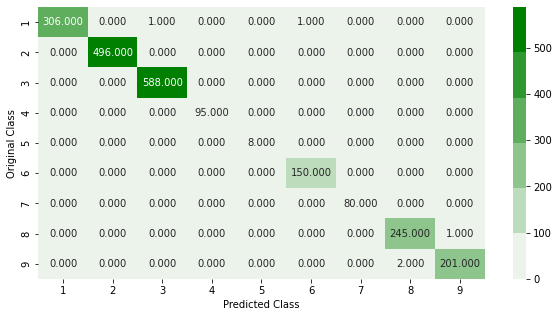

-------------------------------------------------- Precision matrix --------------------------------------------------


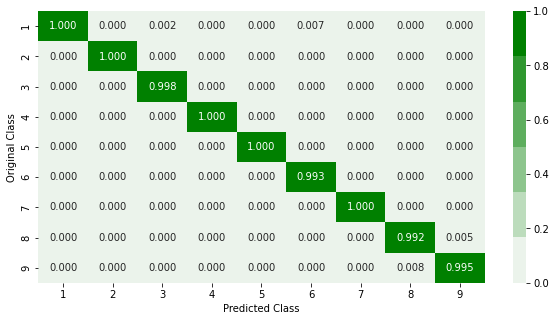

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


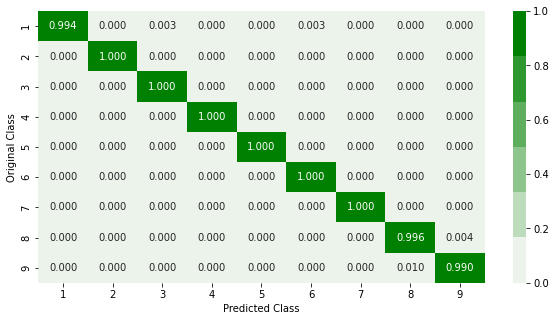

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
import seaborn as sns
plot_confusion_matrix(y_test, c_cfl.predict(X_test))